In [1]:
%matplotlib widget
import sys
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from importlib import reload

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)

from evaluate import *

In [2]:
# fig_dir = Path("../runs/flexible_hybrid/_figures")
# exp_dict = {
#     'All Data': Path("../runs/flexible_hybrid/all_data_20241003_205648"),
#     'ERA5 & Landsat': Path("../runs/flexible_hybrid/no_static_20241003_205137"),
#     'ERA5 & Static': Path("../runs/flexible_hybrid/no_landsat_20241003_205115"),
#     'ERA5 only': Path("../runs/flexible_hybrid/era5_only_20241003_205018"),
#     'Landsat & Static': Path("../runs/flexible_hybrid/no_era5_20241003_205127"),
#     'Landsat only': Path("../runs/flexible_hybrid/landsat_only_20241003_205027")
# }

fig_dir = Path("../runs/Flex_TEALSTM/_figures")
exp_dict = {
    'All Data': Path("../runs/Flex_TEALSTM/all_data_20241105_181617"),
    'ERA5 & Landsat': Path("../runs/Flex_TEALSTM/no_static_20241105_182649"),
    'ERA5 & Static': Path("../runs/Flex_TEALSTM/no_landsat_20241105_181610"),
    'ERA5 only': Path("../runs/Flex_TEALSTM/era5_only_20241105_182632"),
    'Landsat & Static': Path("../runs/Flex_TEALSTM/no_era5_20241105_181611"),
    'Landsat only': Path("../runs/Flex_TEALSTM/landsat_only_20241105_182646")
}

# fig_dir = Path("../runs/lstm_mlp/_figures")
# exp_dict = {
#     'All Data': Path("../runs/lstm_mlp/all_data_20241105_180934"),
#     'ERA5 & Landsat': Path("../runs/lstm_mlp/no_static_20241105_181727"),
#     'ERA5 & Static': Path("../runs/lstm_mlp/no_landsat_20241105_180933"),
#     'ERA5 only': Path("../runs/lstm_mlp/era5_only_20241105_181954"),
#     'Landsat & Static': Path("../runs/lstm_mlp/no_era5_20241105_180935"),
#     'Landsat only': Path("../runs/lstm_mlp/landsat_only_20241105_182010")
# }


# Define colors and styles
both_color = '#d95f02'
ls_color = '#1b9e77'
e5_color = '#7570b3'
line_styles = [
    (both_color,'-'),
    (both_color,'--'),
    (e5_color,'-'),
    (e5_color,'--'),
    (ls_color,'-'),
    (ls_color,'--')
]
# Create custom legend elements
legend_elements = [
    mp.lines.Line2D([0], [0], color=both_color, lw=2, label='ERA5 & Landsat'),
    mp.lines.Line2D([0], [0], color=e5_color, lw=2, label='ERA5'),
    mp.lines.Line2D([0], [0], color=ls_color, lw=2, label='Landsat'),
    mp.lines.Line2D([0], [0], color=None, lw=0, label=''),
    mp.lines.Line2D([0], [0], color='black', lw=2, linestyle='-', label='With Static'),
    mp.lines.Line2D([0], [0], color='black', lw=2, linestyle='--', label='Without Static')
]           

exp_names = []
results = []
bulk_metrics = []
basin_metrics = []
predict_results = []
for exp_name, exp_dir in exp_dict.items():
    exp_names.append(exp_name)
    with open(exp_dir / "test_data.pkl", 'rb') as f:
        r, bulk_m, basin_m = pickle.load(f)
        
        # for feat in ['usgs_q']:
        for feat in ['ssc','flux','usgs_q']:
            lt10 = basin_m[feat]['num_obs'] < 10
            basin_m.loc[lt10, feat] = np.nan
        
        results.append(r)
        bulk_metrics.append(bulk_m)
        basin_metrics.append(basin_m)
        
    with open(exp_dir / "predict_data.pkl", 'rb') as f:
        r, _, _ = pickle.load(f)
        predict_results.append(r)
        
fig_dir.mkdir(exist_ok=True, parents=True)

In [4]:
bulk_metrics[0]['flux']

{'num_obs': np.int64(14088),
 'R2': 0.475848913192749,
 'MAPE': np.float64(343.7032628838661),
 'nBias': np.float32(-22.675892),
 'RE': np.float32(142.82687),
 'RB': np.float32(-29.325783),
 'qRE': array([ 53.12222375, 142.82685697, 394.69300446]),
 'qnBias': array([-67.43335277, -22.67589346,  88.33143711]),
 'MAE': np.float32(26753.158),
 'RMSE': np.float32(118847.164),
 'rRMSE': np.float32(372.6907),
 'KGE': np.float64(0.49879002952971296),
 'NSE': np.float32(-0.19364822),
 'Agreement': np.float32(0.6364304)}

In [51]:
# MONTHLY KGE

import evaluate 

# Group by basin and month, then calculate the mean for predicted and observed discharge
daily_df = results[0].copy()
daily_df['yyyy-mm'] = daily_df.index.get_level_values('date').to_period('M')
monthly_avg = daily_df.groupby(['basin', 'yyyy-mm']).mean()

# Drop NaNs to prevent issues in the KGE calculation
monthly_avg = monthly_avg.dropna()

# Apply KGE calculation per basin
kge_results = monthly_avg.groupby('basin').apply(
    lambda group: evaluate.metrics.calc_kge(group['obs']['usgs_q'], group['pred']['usgs_q'])
)

# Convert to a DataFrame for better readability
kge_results = kge_results.rename('KGE')
(kge_results>0.2).mean()

np.float64(0.65)

In [49]:
cohen_q = [0.48, 0.49, 0.51, 0.18, 0.48, 0.30, 0.18, 0.34, 0.53, 0.25]
cohen_s = [0.64, 0.36, 0.39, 0.68, 0.38, 0.21, 0.35, 0.3, 0.14, 0.12, 0.67, 0.50, 0.17]

np.median(cohen_s)

np.float64(0.36)

In [51]:
import sklearn.metrics as skm
from evaluate.metrics import mask_nan
from scipy.optimize import curve_fit

var = 'flux'
def log_r2(df):
    x = df['obs'][var]
    y = df['pred'][var]
    
    return mask_nan(skm.r2_score)(np.log10(x),np.log10(y))

out = results[0].groupby('basin').apply(log_r2)
out.median()

np.float64(0.2850123643875122)

In [50]:
results[0].index.get_level_values('basin').unique()

Index(['USGS-08049500', 'USGS-03234500', 'USGS-05330000', 'USGS-03085000',
       'USGS-05454500', 'USGS-04073500', 'USGS-06090800', 'USGS-07182250',
       'USGS-06192500', 'USGS-06807000',
       ...
       'USGS-01198550', 'USGS-03109670', 'USGS-07178050', 'USGS-05435800',
       'USGS-03075001', 'USGS-02387050', 'USGS-05464020', 'USGS-03274600',
       'USGS-07367640', 'USGS-04126010'],
      dtype='object', name='basin', length=126)

0.7399382591247559

In [74]:
dt_mask = (results[0]['dt']>=365).any(axis=1)

sat_results = results[0][dt_mask].copy()
nosat_results = results[1][dt_mask.reindex(results[1].index).fillna(False)].copy()

sat_bulk_metrics = get_all_metrics(sat_results)
sat_basin_metrics = get_basin_metrics(sat_results)

nosat_bulk_metrics = get_all_metrics(nosat_results)
nosat_basin_metrics = get_basin_metrics(nosat_results)

/tmp/ipykernel_544677/2438018837.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  nosat_results = results[1][dt_mask.reindex(results[1].index).fillna(False)].copy()


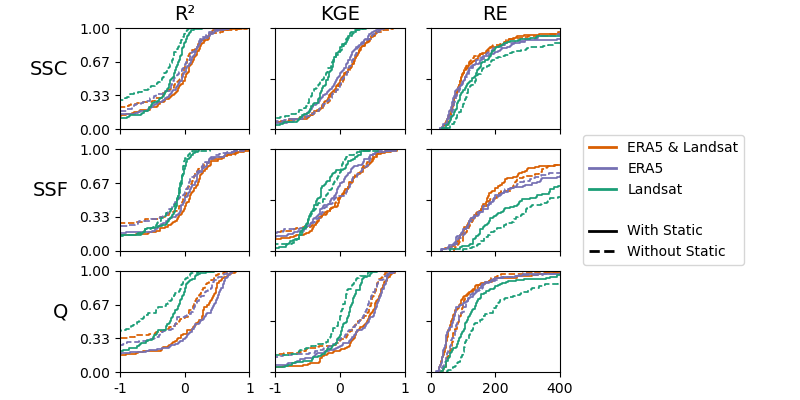

In [52]:
plt.close('all')

metric_args = {
    'R2':{'range':[-1,1]},
    'KGE':{'range':[-1,1]},
    'RE': {'range':[0,400]}
    }

feature_labels = ['SSC', 'SSF', 'Q']
features = ['ssc', 'flux', 'usgs_q']
nRows = len(features)
nCols = len(metric_args)
fig, axes = plt.subplots(nRows, nCols, figsize=(8, 4))

for feature, axes_row in zip(features, axes):
    for (metric, metric_kwargs), ax in zip(metric_args.items(), axes_row):
        for m, (c, s) in zip(basin_metrics, line_styles):
            if (feature, metric) not in m:
                continue
            x = m[feature, metric].astype(float)
            x = x[np.isfinite(x)]
            
            if 'bias' in metric.lower():
                x = np.abs(x)
                
            ax.ecdf(x, color=c, linestyle=s, linewidth=1.25)
        
        # ax.set_aspect(1./ax.get_data_ratio())
        ax.set_xlim(metric_kwargs['range'])
        ax.set_ylim([0,1])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        
# Top Axes
for metric, ax in zip(['R²','KGE','RE'], axes[0,:]):
    ax.set_title(metric, fontsize=14)
    
# Bottom Axes
for ax in axes[-1,:]:
    ax.set_xticks(np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 3))
    ax.set_xticklabels([int(label) for label in np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 3)])
    
# Left Axes
for label, ax in zip(feature_labels, axes[:,0]):
    ax.set_ylabel(label, rotation=0, ha='right', fontsize=14, labelpad=8)
    ax.set_yticks(np.linspace(0, 1, 4))
    ax.set_yticklabels([f"{lab:0.2f}" for lab in np.linspace(0, 1, 4)])
    

# Adjust spacing to make room for the legend
plt.subplots_adjust(top=0.93, bottom=0.07, left=0.15, right=0.7)

fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.72, 0.5))


# fig.tight_layout()
plt.show()

fig.savefig(fig_dir / "ablation_cdfs.png",  dpi=300)

In [ ]:
obs = basin_metrics[2]['flux']['num_obs'] > 50
r2 = basin_metrics[2]['flux']['R2'] > 0
kge = basin_metrics[0]['flux']['KGE']> 0.3
nse = basin_metrics[0]['usgs_q']['NSE']> 0.20
mask = obs & r2 & kge# & nse

bias_change = np.abs(basin_metrics[2]['flux']['nBias']) - np.abs(basin_metrics[0]['flux']['nBias'])
basin = bias_change[mask].idxmax()
# basin_metrics[0].loc[basin]

In [208]:
obs = basin_metrics[0]['flux']['num_obs'] > 100
r2 = basin_metrics[0]['flux']['R2'] > 0
kge = basin_metrics[0]['flux']['KGE']> 0
nse = basin_metrics[0]['usgs_q']['NSE']> 0
mask = obs & r2 & kge & nse
print(sum(mask))

basin = basin_metrics[0][mask].sample(1).index[0]
print(basin)
# basin_metrics[0].loc[basin]

print(basin_metrics[0].loc[basin,('flux','RB')])
print(basin_metrics[2].loc[basin,('flux','RB')])

15
USGS-12392000
5.612397
-6.0483694


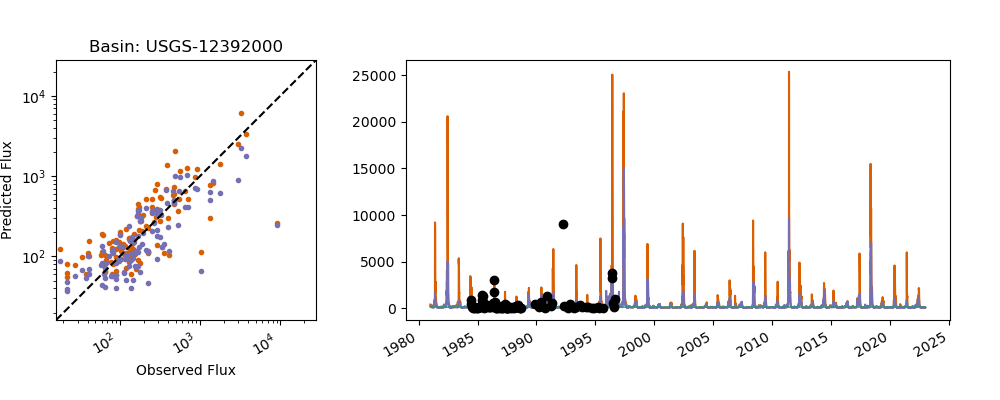

In [209]:
import matplotlib.gridspec as gridspec

"""
USGS-12510500 good improvement in bias.
"""

# Plot the true values and predictions
plt.close('all')

# Create a figure
fig = plt.figure(figsize=(10, 4))

# Create a GridSpec with 1 row and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.2, 2])
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 2])]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

legend_elements = []
mins, maxs = [], []
for preds, name, (c, s) in zip(predict_results, exp_names, line_styles):
    if s == '--':
        continue
    
    basin_mask  = preds.index.get_level_values('basin') == basin
    sorted_df = preds[basin_mask].sort_values('date')
    
    date = sorted_df.index.get_level_values('date')
    values = sorted_df['pred']['flux'].values
    obs = sorted_df['obs']['flux'].values
     
    if not 'era5' in preds['dt'].columns:
        #Remove the predictions with no query basis
        mask = sorted_df['dt']['landsat'] == 0
        masked_date = date[mask]
        masked_values = values[mask]
        masked_obs = obs[mask]
        axes[0].scatter(masked_obs, masked_values, marker='.',color=c)
        l = axes[1].scatter(masked_date, masked_values, 15, marker='s', color=c, label=name)#, facecolor='none')
        l = axes[1].plot(date, values, linewidth=1, color=c, label=name)#, facecolor='none')
    else:
        axes[0].scatter(obs, values, marker='.',color=c)
        l = axes[1].plot(date, values, color=c, label=name)
    
    legend_elements.append(l)
        
    mins.extend([np.nanmin(values), np.nanmin(obs)])
    maxs.extend([np.nanmax(values), np.nanmax(obs)])
    
    
axes[1].scatter(date, obs, zorder=10, color='k')

min_val = float(np.min(mins))*0.9
max_val = float(np.max(maxs))*1.1
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--')

# Setting axes to be square and equal range
axes[0].axis('square')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(min_val, max_val)
axes[0].set_ylim(min_val, max_val)
axes[0].set_xlabel(f"Observed Flux")
axes[0].set_ylabel(f"Predicted Flux")
axes[0].set_title(f"Basin: {basin}")

# axes[1].set_yscale('log')

fig.subplots_adjust(top=0.85, left=0.05, right=0.95, wspace=0.05, hspace=0.4)
fig.autofmt_xdate()

plt.show()

# fig.savefig(fig_dir / f"{basin}_timeseries.png",  dpi=300)

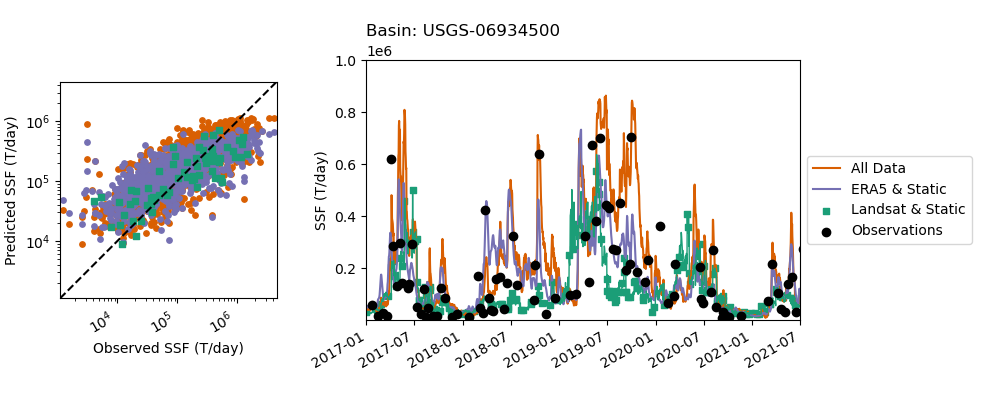

In [82]:
import matplotlib.gridspec as gridspec

"""
# dynamics and strong seasonal cycle, but no Landsat.
basin = 'USGS-13013650'
start_date = np.datetime64('1995-01-01')
end_date = np.datetime64('1999-07-01')
y_max = 100000
log = True

basin = 'USGS-04183500'
start_date = np.datetime64('2017-01-01')
end_date = np.datetime64('2017-07-01')
y_max = 50000
log = False
"""

basin = 'USGS-06934500'
start_date = np.datetime64('2017-01-01')
end_date = np.datetime64('2021-07-01')
y_max = 1000000
log = False

# Plot the true values and predictions
plt.close('all')

# Create a figure
fig = plt.figure(figsize=(10, 4))

# Create a GridSpec with 1 row and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.2, 2])
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 2])]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

legend_elements = []
mins, maxs = [], []
for preds, name, (c, s) in zip(predict_results, exp_names, line_styles):
    if s == '--':
        continue
    
    basin_mask  = preds.index.get_level_values('basin') == basin
    sorted_df = preds[basin_mask].sort_values('date')
    
    date = sorted_df.index.get_level_values('date')
    values = sorted_df['pred']['flux'].values
    obs = sorted_df['obs']['flux'].values
     
    if not 'era5' in preds['dt'].columns:
        #Remove the predictions with no query basis
        mask = sorted_df['dt']['landsat'] == 0
        masked_date = date[mask]
        masked_values = values[mask]
        masked_obs = obs[mask]
        axes[0].scatter(masked_obs, masked_values, 15, marker='s',color=c)
        axes[1].plot(date, values, linewidth=1, color=c, label=name)#, facecolor='none')
        l = axes[1].scatter(masked_date, masked_values, 15, marker='s', color=c, label=name)#, facecolor='none')
        legend_elements.append(l)
    else:
        axes[0].scatter(obs, values, 15, marker='o',color=c)
        l = axes[1].plot(date, values, color=c, label=name)
        legend_elements.append(l[0])
    
    mins.extend([np.nanmin(values), np.nanmin(obs)])
    maxs.extend([np.nanmax(values), np.nanmax(obs)])
    
    
l = axes[1].scatter(date, obs, color='k', zorder=10, label='Observations')
legend_elements.append(l)

min_val = float(np.min(mins))*0.9
max_val = float(np.max(maxs))*1.1
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--')

# Setting axes to be square and equal range
axes[0].axis('square')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(min_val, max_val)
axes[0].set_ylim(min_val, max_val)
axes[0].set_xlabel(f"Observed SSF (T/day)")
axes[0].set_ylabel(f"Predicted SSF (T/day)")
axes[1].set_title(f"Basin: {basin}", loc='left')

axes[1].set_xlim(start_date, end_date)
axes[1].set_ylim(1, y_max)
axes[1].set_ylabel("SSF (T/day)")
if log:
    axes[1].set_yscale('log')

fig.subplots_adjust(top=0.85, left=0.06, right=0.8, wspace=0.1, hspace=0.4)
fig.autofmt_xdate()


fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.8, 0.5))


plt.show()

fig.savefig(fig_dir / f"{basin}_zoom_timeseries.png",  dpi=300)

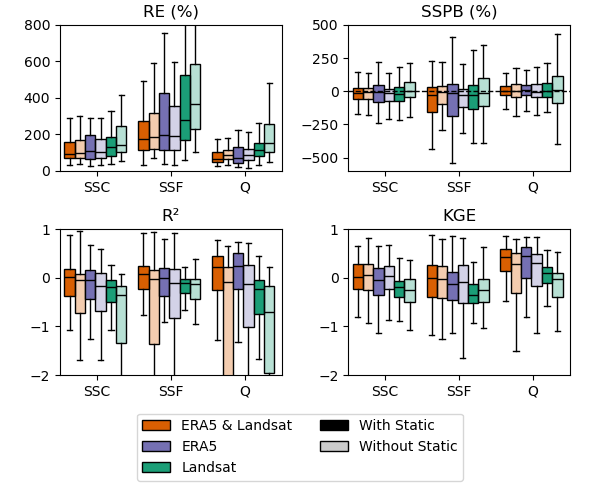

In [53]:
num_models = len(results)
target_variables = ['ssc','flux','usgs_q']
num_targets = len(target_variables)

colors = [t[0] for t in line_styles]
lines = [t[1] for t in line_styles]
face_colors = [c + ('' if l=='-' else '50') for c, l in zip(colors,lines)]

# Box width and spacing adjustments
box_width = 0.14
offset = box_width * (num_models / 2)

metric_names = {'RE':'RE (%)', 
                'RB':'SSPB (%)',
                'R2': 'R²',
                'KGE': 'KGE'}

n_metrics = len(metric_names)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 5))
axes= axes.flatten()

for ax, (mkey, mname) in zip(axes, metric_names.items()):
    for j, var in enumerate(target_variables):
        positions = np.array([j + (i - num_models / 2 + 0.35) * box_width for i in range(num_models)])
        box_data = [np.array(m[var][mkey], dtype=float) for m in basin_metrics]
        
        box_data = [x[~np.isnan(x)] for x in box_data]

        box = ax.boxplot(box_data, positions=positions, widths=box_width,
                         patch_artist=True, medianprops={'color':'black'}, showfliers=False)
        
        for patch, face_color in zip(box['boxes'], face_colors):
            patch.set_facecolor(face_color)
            
        ax.set_title(mname)

    ax.set_xticks(np.arange(num_targets))
    ax.set_xticklabels(['SSC','SSF','Q'])
    ax.set_xlim([-0.5, 2.5])
    

# Modify axes, legends, etc. as needed
axes[0].set_ylim([0, 800])

axes[1].plot([-1, 3], [0, 0], 'k', linestyle='--', linewidth=1, zorder=10)
axes[1].set_ylim([-600, 500])

# axes[2].plot([-1, 3], [0, 0], 'k', linestyle='--', linewidth=1, zorder=10)
axes[2].set_ylim([-2, 1])

axes[3].set_ylim([-2, 1])


# Create custom legend elements
legend_elements = [
    mp.patches.Rectangle((0, 0), 1, 1, color=both_color, ec='black', label='ERA5 & Landsat'),
    mp.patches.Rectangle((0, 0), 1, 1, color=e5_color, ec='black', label='ERA5'),
    mp.patches.Rectangle((0, 0), 1, 1, color=ls_color, ec='black', label='Landsat'),
    mp.patches.Rectangle((0, 0), 1, 1, color=(0, 0, 0), label='With Static'),
    mp.patches.Rectangle((0, 0), 1, 1, facecolor=(0.8, 0.8, 0.8), edgecolor=(0,0,0), label='Without Static'),
]

fig.subplots_adjust(left=0.1, right=0.95, bottom=0.25, top=0.95, wspace=0.3, hspace=0.4)
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.025), ncol=2)

plt.show()

fig.savefig(fig_dir / f"basin_boxplots_zoom.png", dpi=300)


In [236]:
avg_dt = results[0]['dt']['landsat'].groupby(level='basin').mean().values
RE_change = (basin_metrics[0]['flux']['RE']- basin_metrics[2]['flux']['RE']).values.astype(float)

In [238]:
results[0]

Type                     obs                           pred               \
Feature                  ssc flux       usgs_q          ssc         flux   
basin         date                                                         
USGS-08049500 2000-05-30 NaN  NaN     7.362381    68.011223    49.591797   
USGS-03234500 1984-05-10 NaN  NaN   239.843658   149.774155  8227.149414   
USGS-05330000 1983-06-10 NaN  NaN   156.875290   234.059418  5224.394043   
USGS-03234500 1995-01-11 NaN  NaN    32.281208     5.365226     8.244576   
USGS-03085000 1992-09-08 NaN  NaN   102.223808    18.721369   299.417511   
...                       ..  ...          ...          ...          ...   
USGS-06882000 2002-02-05 NaN  NaN     7.362381    26.100765     9.324088   
USGS-09371010 2012-08-18 NaN  NaN    14.300009  1190.486328  1591.156006   
USGS-07308500 1996-08-29 NaN  NaN   478.554657   147.422501    92.162560   
USGS-05526000 1987-03-18 NaN  NaN    22.653477    39.968819   457.526672   
USGS-05586100 2009-12-07 NaN  NaN  1206.297852    45.175453  2211.854004   

Type                                   dt          
Feature                       usgs_q era5 landsat  
basin         date                                 
USGS-08049500 2000-05-30    7.744249    0       7  
USGS-03234500 1984-05-10  477.745728    0     366  
USGS-05330000 1983-06-10  229.264069    0     366  
USGS-03234500 1995-01-11   13.978035    0      65  
USGS-03085000 1992-09-08  173.436279    0       8  
...                              ...  ...     ...  
USGS-06882000 2002-02-05    3.555387    0      16  
USGS-09371010 2012-08-18   16.138575    0      47  
USGS-07308500 1996-08-29    4.564307    0      22  
USGS-05526000 1987-03-18   99.247955    0      36  
USGS-05586100 2009-12-07  449.527008    0       2  

[1135552 rows x 8 columns]

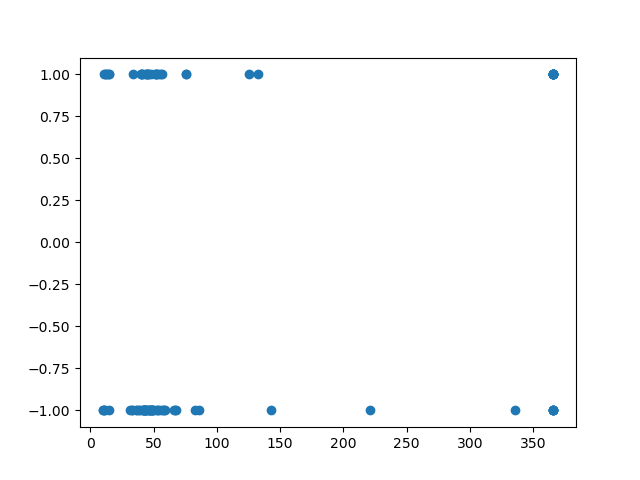

In [237]:
plt.close('all')
plt.scatter(avg_dt,np.sign(RE_change))

In [235]:
basin_metrics[0]['flux']['RE'].values.astype(float)

array([  62.96199417,           nan,   73.32421875,  139.93380737,
        177.04624939,  170.96815491,  180.85835266, 1025.52111816,
                 nan,           nan,           nan,           nan,
         93.99062347,           nan,           nan,   77.30312347,
        425.04434204,           nan,  150.94927979,           nan,
        133.25186157,  127.1999588 ,   75.9888382 ,  149.82054138,
         80.34044647,  164.92471313,           nan,  122.61740875,
                 nan,  183.05702209,  271.83856201,  114.15602875,
        196.31826782,           nan,           nan,   30.68987083,
        116.59645844,           nan,           nan,           nan,
         91.77459717,  200.76577759,  125.0831604 ,  266.91433716,
       2520.62255859,   87.91965485,  100.08368683,  165.50497437,
                 nan,           nan,           nan,           nan,
        560.59997559,   95.95396423,  118.96889496,  147.00648499,
                 nan,  175.37486267,           nan,  191.11340

In [223]:
np.sign(RE_change)

TypeError: unorderable types for comparison

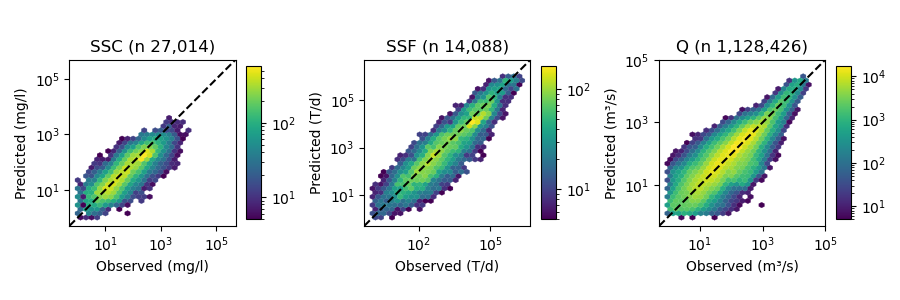

In [54]:
def hexbin_1to1(ax, x, y, target, target_label, max_val, unit):
    positive_mask = (x > 0) & (y > 0)
    x = x[positive_mask]
    y = y[positive_mask]

    min_val = 5E-1
    log_min = np.log10(min_val)
    log_max = np.log10(max_val)

    hb = ax.hexbin(x, y, gridsize=(30,20), bins='log', mincnt=5,
                linewidth=0.2,
                extent=(log_min, log_max, log_min, log_max),
                xscale='log', yscale='log')
    plt.colorbar(hb, shrink=0.6, aspect=10, anchor=(0,0.5))

    # Add a 1:1 line over the min and max of x and y
    ax.plot([min_val, max_val], [min_val, max_val], 'k--')

    # Setting axes to be square and equal range
    ax.axis('square')
    ax.set_xlim(min_val, max_lim)
    ax.set_ylim(min_val, max_lim)
    ax.set_title(f"{target_label} (n {len(x):,})")
    ax.set_xlabel(f'Observed ({unit})')
    ax.set_ylabel(f'Predicted ({unit})')

    

targets = ['ssc','flux','usgs_q']
target_labels = ['SSC', 'SSF', 'Q']
units = ['mg/l', 'T/d', 'm³/s']
max_lims = [5E5, 5E6, 1E5]

fig, axes = plt.subplots(1,len(targets), figsize=(len(targets)*3, 3))

idx_plot = 0
axes = [axes] if len(targets)==1 else axes        
for target, target_label, unit, max_lim, ax in zip(targets, target_labels, units, max_lims, axes):
    dt_mask = results[idx_plot]['dt'].max(axis=1) >= 0
    x = results[idx_plot]['obs'][target]
    y = results[idx_plot]['pred'][target]
    hexbin_1to1(ax, x[dt_mask], y[dt_mask], target, target_label, max_lim, unit)


plt.tight_layout()

fig.savefig(fig_dir / f"bulk_scatterplots.png", dpi=300)

In [34]:
bulk_metrics[0]

{'ssc': {'num_obs': np.int64(27003),
  'R2': 0.21511399745941162,
  'MAPE': np.float64(112.75450599153471),
  'nBias': np.float32(-16.07625),
  'RE': np.float32(82.24132),
  'RB': np.float32(-19.155788),
  'qRE': array([ 33.30035007,  82.24133005, 191.6738157 ]),
  'qnBias': array([-52.2393316 , -16.07625037,  54.74826097]),
  'MAE': np.float32(187.85109),
  'RMSE': np.float32(1136.4482),
  'rRMSE': np.float32(780.46924),
  'KGE': np.float64(0.08884268480146196),
  'NSE': np.float32(-4.0651836),
  'Agreement': np.float32(0.32500768)},
 'flux': {'num_obs': np.int64(14081),
  'R2': 0.4755067825317383,
  'MAPE': np.float64(343.75931768965717),
  'nBias': np.float32(-22.702269),
  'RE': np.float32(142.81993),
  'RB': np.float32(-29.369904),
  'qRE': array([ 53.13128008, 142.81992421, 394.91017228]),
  'qnBias': array([-67.46041179, -22.70226777,  88.16398382]),
  'MAE': np.float32(26757.102),
  'RMSE': np.float32(118872.81),
  'rRMSE': np.float32(372.98834),
  'KGE': np.float64(0.498561542

In [60]:
import sklearn.metrics as skm

def get_log_r2(df):
    x = df['obs']['flux']
    y = df['pred']['flux']
    positive_mask = (x > 0) & (y > 0)
    x = x[positive_mask]
    y = y[positive_mask]
    
    if len(x) > 10:
        return skm.r2_score(np.log10(x),np.log10(y))
    else:
        return np.nan

r2 = results[0].groupby(level='basin').apply(get_log_r2)
r2.median()

np.float64(0.32172825932502747)

In [42]:
basin_metrics[0]['flux']

Metric,num_obs,R2,MAPE,nBias,RE,RB,qRE,qnBias,MAE,RMSE,rRMSE,KGE,NSE,Agreement
USGS-01049265,86,0.811611,191.853237,43.293034,70.563576,43.292629,"[26.968622995962033, 70.56358788264328, 200.40...","[-7.384832203388214, 43.29303503036499, 162.52...",231.857101,632.840454,154.034393,0.667433,0.594755,0.871439
USGS-01198550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
USGS-01443000,18,0.991146,109.723078,5.073632,89.376129,5.045068,"[13.764775615543524, 89.37613882823783, 195.09...","[-15.642365626990795, 5.07363136857748, 133.69...",54.566566,93.799728,24.392275,0.933568,0.992,0.995798
USGS-01474500,82,0.100259,179.029688,62.378849,137.885925,62.378681,"[62.262144450595216, 137.8859063490836, 418.72...","[-34.63496342301369, 62.37884759902954, 193.34...",1708.3927,7713.799316,2565.308838,-0.252749,-105.37999,0.137614
USGS-01567000,214,-0.70161,263.661005,99.849228,180.250305,99.843147,"[83.13324443700347, 180.25029510299328, 435.39...","[-23.19689318537712, 99.84923005104065, 325.25...",6381.231445,18723.158203,262.324463,0.056412,0.038619,0.394298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USGS-13342500,127,0.047707,102.935524,-71.839584,266.074707,-255.108353,"[101.55105549972791, 266.0747146392033, 561.85...","[-84.15361642837524, -71.83958292007446, -23.5...",1898.69519,5946.240723,1361.562012,-0.258508,-42.22345,0.146433
USGS-14211720,295,0.625657,99.127312,-56.381966,184.43808,-129.26297,"[70.3103687942906, 184.43812150409556, 519.282...","[-81.77861869335175, -56.381964683532715, -8.8...",2596.579346,9946.685547,320.376434,0.475424,-0.052821,0.725048
USGS-14321000,28,0.317664,127.419214,37.417877,113.413383,37.383236,"[15.972316173826684, 113.4133975188615, 257.25...","[7.890508323907852, 37.41787672042847, 171.160...",262.763153,765.986389,275.646637,0.249943,-2.167223,0.449368
USGS-383103106594200,52,0.09397,78.701787,-59.028118,163.508057,-144.247849,"[64.98030412744068, 163.50807412544373, 448.84...","[-81.04019910097122, -59.02811884880066, -1.44...",248.654709,884.935242,908.083801,-0.177319,-17.480438,0.172735


In [ ]:
import evaluate
evaluate.get_all_metrics(results[0][dt_mask])

In [121]:
cfg = {'step_kwargs':{'aaa':1, 'bbb':2}}
cfg.get('target_weights',{}).get('ssc', 1)

1

In [ ]:
matchups

In [ ]:
plt.close('all')
sites[metric].hist()

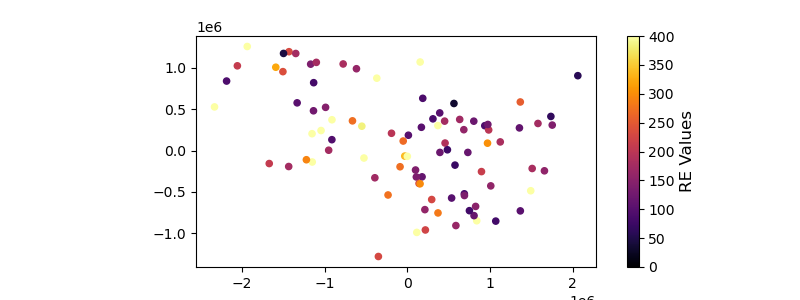

In [35]:
from matplotlib.colors import Normalize


sites = pd.read_csv('/work/pi_kandread_umass_edu/tss-ml/data/NA_WQP/preprocess/hydrography_matchups.csv',index_col='wqp_id')
geom = gpd.GeoSeries.from_wkt(sites.geometry)
sites = gpd.GeoDataFrame(sites, geometry = geom)

var = 'flux'
metric = 'RE'

sites = sites.merge(basin_metrics[0][var][metric], left_index=True, right_index=True)
sites[metric] = sites[metric].astype(float)

plt.close('all')

# Create a plot with GeoPandas
fig, ax = plt.subplots(figsize=(8, 3))

# Define the normalization from -1 to 1
# norm = Normalize(vmin=-1, vmax=1)
# cmap = 'RdYlBu'

norm = Normalize(vmin=0, vmax=400)
cmap = 'inferno'

# Plot the data, specifying 'KGE' as the column, and applying the colormap and normalization
sites.plot(column=metric, cmap=cmap, norm=norm, markersize=20, ax=ax)

# Add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Empty array to avoid warnings
cbar = fig.colorbar(sm, ax=ax)

# Optional: Set colorbar label
cbar.set_label(f'{metric} Values', fontsize=12)

plt.show()